## Домашняя работа
Найти данные о заболеваемости/смертности/выздоровлении COVID-19 (они есть например на Kaggle) и использовать их для решения заданий. Можно использовать как данные по какому-то конкретному региону/стране, так и данные по всему миру.

Скорее всего, результат по всем задачам получится не очень.

## Easy
Проверить ряд на стационарность. Привести ряд к стационарному виду.

Построить прогноз заболеваемости, используя модель ARIMA, на месяц вперед. Подобрать оптимальные параметры модели. Визуализировать результат. Выглядит ли такой прогноз реалистичным?

Для решения задачи можно использовать pmdarima

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [196]:
df = pd.read_csv(r'D:\Курсы Питон\covid_jpn_prefecture.csv', index_col=0, parse_dates=True)
df

,Prefecture,Positive,Tested,Discharged,Fatal,Hosp_require,Hosp_severe
Date,,,,,,,
2020-03-18,Hokkaido,154,1587.0,69.0,7.0,NaN,NaN
2020-03-18,Aomori,0,75.0,0.0,0.0,NaN,NaN
2020-03-18,Iwate,0,24.0,0.0,0.0,NaN,NaN
2020-03-18,Miyagi,1,138.0,1.0,0.0,NaN,NaN
2020-03-18,Akita,2,109.0,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
2022-07-22,Kumamoto,154729,348863.0,134586.0,336.0,19807.0,5.0
2022-07-22,Oita,76588,678048.0,66256.0,176.0,10156.0,0.0
2022-07-22,Miyazaki,73991,201123.0,64450.0,153.0,9275.0,1.0


In [197]:
df_vr = df.groupby("Date").sum()

In [198]:
# обработка трех дат, когда корректировали статистику по заболевшим
df_vr.loc["2020-03-26", 'Positive' ] = 1354
df_vr.loc["2020-11-09", 'Positive' ] = 107657
df_vr.loc["2022-03-16", 'Positive' ] = 5926625

In [199]:
df_vr['n_confirmed'] = df_vr['Positive'].diff()

In [200]:
df_vr = df_vr.drop(['Tested', 'Discharged', 'Hosp_severe'], axis=1)

In [201]:
df_vr.loc[(df_vr['n_confirmed'] < 0)]

,Positive,Fatal,Hosp_require,n_confirmed
Date,,,,


In [183]:
dff_vr = df_vr.dropna(subset=['n_confirmed'])

<AxesSubplot:xlabel='Date'>

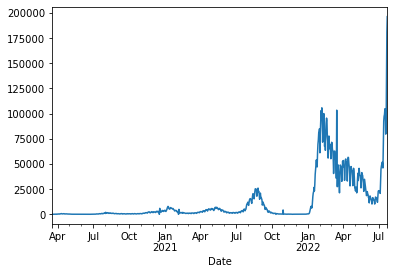

In [184]:
dff_vr['n_confirmed'].plot()

In [131]:
import statsmodels.tsa.stattools

In [132]:
# Критерий KPSS (Kwiatkowski–Phillips–Schmidt–Shin)
stat, p_value, *_ = statsmodels.tsa.stattools.kpss(dff_vr['n_confirmed'])
stat, p_value

D:\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(2.1226955234020997, 0.01)

Согласно результату теста KPSS временной ряд нестационарный (p = 0.01, т.е. отвергаем нулевую гипотезу о стационарности временного ряда).

In [133]:
# DF-тест (Dickey — Fuller test)
stat, pvalue, *_ = statsmodels.tsa.stattools.adfuller(dff_vr['n_confirmed'])
stat, pvalue

(-0.18333146532945727, 0.940479516384296)

Согласно результату теста Дики-Фуллера временной ряд нестационарный (p = 0.94, т.е. принимаем нулевую гипотезу о нестационарности временного ряда).

In [134]:
from statsmodels.tsa.arima.model import ARIMA 

In [176]:
model_fit = ARIMA(dff_vr['n_confirmed'], order=(4, 2, 5)).fit()
print('AIC=', model_fit.aic)

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC= 17023.620217281306


D:\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='Date'>

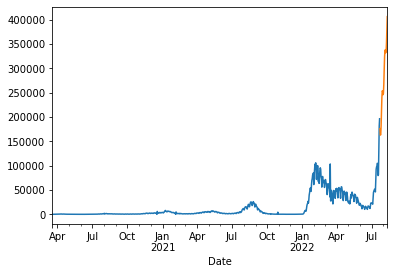

In [185]:
dff_vr['n_confirmed'].plot()
model_fit.forecast(20).plot()

In [186]:
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

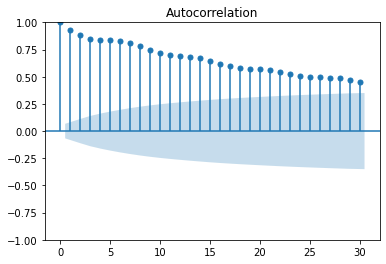

In [187]:
plot_acf(dff_vr['n_confirmed'])
plt.show()

D:\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


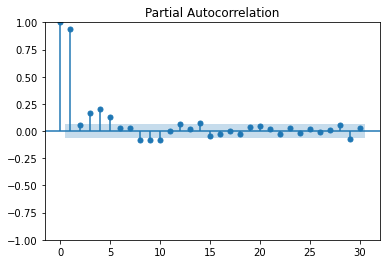

In [188]:
plot_pacf(dff_vr['n_confirmed'])
plt.show()

In [190]:
from statsmodels.tsa.arima.model import ARIMA

In [191]:
n_sample = len(dff_vr['n_confirmed'])
pivot = int(0.8 * n_sample)
x_train, x_test = dff_vr['n_confirmed'].iloc[:pivot], dff_vr['n_confirmed'].iloc[pivot:]

In [192]:
from itertools import product

In [170]:
p_list = [2, 3, 4, 5, 6, 7, 8, 9]
d_list = [0, 1, 2, 3, 4]
q_list = [0, 1, 2, 3, 4, 5]

best_aic = 20000
best_params = (None, None, None)
for p, d, q in product(p_list, d_list, q_list):
    model = ARIMA(x_train, order=(p, d, q)).fit()
    if model.aic < best_aic:
        best_aic = model.aic
        x_pred = model.forecast(len(x_test))
        best_params = (p, d, q)

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\stat

LinAlgError: LU decomposition error.

In [193]:
best_params

(4, 2, 5)

In [203]:
df_vr['n_fatal'] = df_vr['Fatal'].diff()
df_vr

,Positive,Fatal,Hosp_require,n_confirmed,n_fatal
Date,,,,,
2020-03-18,890,31.0,0.0,NaN,NaN
2020-03-19,926,33.0,0.0,36.0,2.0
2020-03-20,975,35.0,0.0,49.0,2.0
2020-03-21,1012,36.0,0.0,37.0,1.0
2020-03-22,1054,41.0,0.0,42.0,5.0
...,...,...,...,...,...
2022-07-18,10367689,31602.0,712415.0,79598.0,16.0
2022-07-19,10449031,31635.0,725682.0,81342.0,33.0
2022-07-20,10584229,31689.0,797212.0,135198.0,54.0


<AxesSubplot:xlabel='Date'>

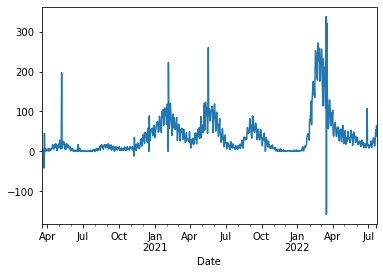

In [204]:
df_vr['n_fatal'].plot()

<AxesSubplot:xlabel='Date'>

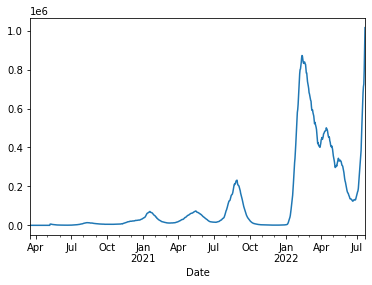

In [205]:
df_vr['Hosp_require'].plot()

In [206]:
# Критерий KPSS (Kwiatkowski–Phillips–Schmidt–Shin)
stat, p_value, *_ = statsmodels.tsa.stattools.kpss(df_vr['Hosp_require'])
stat, p_value

D:\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(2.075658948574784, 0.01)

In [208]:
n_sample = len(df_vr['Hosp_require'])
pivot = int(0.8 * n_sample)
x_train2, x_test2 = df_vr['Hosp_require'].iloc[:pivot], df_vr['Hosp_require'].iloc[pivot:]

In [209]:
p_list = [2, 3, 4, 5, 6, 7, 8, 9]
d_list = [0, 1, 2, 3, 4]
q_list = [0, 1, 2, 3, 4, 5]

best_aic = 20000
best_params = (None, None, None)
for p, d, q in product(p_list, d_list, q_list):
    model = ARIMA(x_train2, order=(p, d, q)).fit()
    if model.aic < best_aic:
        best_aic = model.aic
        x_pred = model.forecast(len(x_test2))
        best_params = (p, d, q)

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\stat

LinAlgError: LU decomposition error.

In [210]:
best_params

(2, 2, 5)

In [211]:
model_fit = ARIMA(df_vr['Hosp_require'], order=(2, 2, 5)).fit()
print('AIC=', model_fit.aic)

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC= 16925.661091924398


<AxesSubplot:xlabel='Date'>

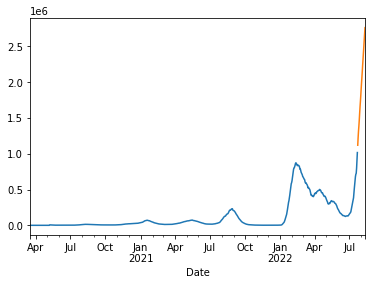

In [212]:
df_vr['Hosp_require'].plot()
model_fit.forecast(20).plot()